In [2]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [5]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_table('data/Chloroplasts_removed/recalculated_mean_HNA_LNA_v2.tsv', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)
#productivity.index = productivity.samples

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [7]:
samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
index = target.index.drop(samples_to_drop)

In [10]:
'''Set sample names as index and shuffle data'''
#productivity = productivity.loc[target.samples.values,:]
#productivity.index= target.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

**-- PREPROCESSING OF DATA --**

**1)**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter $abun$. 

In [9]:
'''Parameter abun for initial filtering of OTUs'''
abun = 0.001

In [11]:
'''Filtering based on productivity samples, not needed for first part of analysis'''
#retain only productivity samples 
productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90) (outliers)
productivity = productivity[productivity.tot_bacprod < 90]

idx_prod = productivity.index.values
#display(idx_prod)
prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
prod_rel_error = prod_error/prod

In [12]:
from analysis_functions import preprocess_df_meanabun
data_rel_prod = preprocess_df_meanabun(data_rel.loc[idx_prod,:],abun,False)
otus_prod = list(data_rel_prod.columns)

print('Number of OTUs: ' + str(len(otus_prod)))

Number of OTUs: 123


(Note that this number is the same whether we use absolute or relative abundances, as the filtering is based on a minimal _relative_ abundance.)

In [13]:
#Some variables to store information and to create inner and outer CV-folds

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [16]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel,otus_prod)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

In [17]:
from analysis_functions import get_lassoCV_alpha, get_r2_corr_scores

alpha = get_lassoCV_alpha(data_stand.loc[:,otus_prod],hna,otus_prod,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus_prod], hna, alpha), index=otus_prod, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna, r2_prod_hna = get_r2_corr_scores(data_stand.loc[:,otus_prod],hna,otus_prod,otu_scores,cv, prod, idx_prod)
thr_otu_scores_lna, r2_otu_scores_lna, r2_prod_lna = get_r2_corr_scores(data_stand.loc[:,otus_prod],lna,otus_prod,otu_scores,cv, prod, idx_prod)

In [18]:
q = otu_scores.mean()*len(otus_prod)
print(q)

score    36.703333
dtype: float64


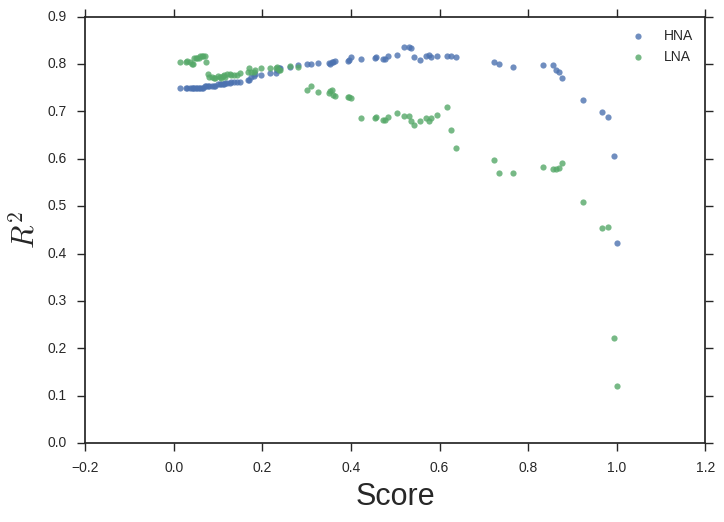

In [19]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.show()

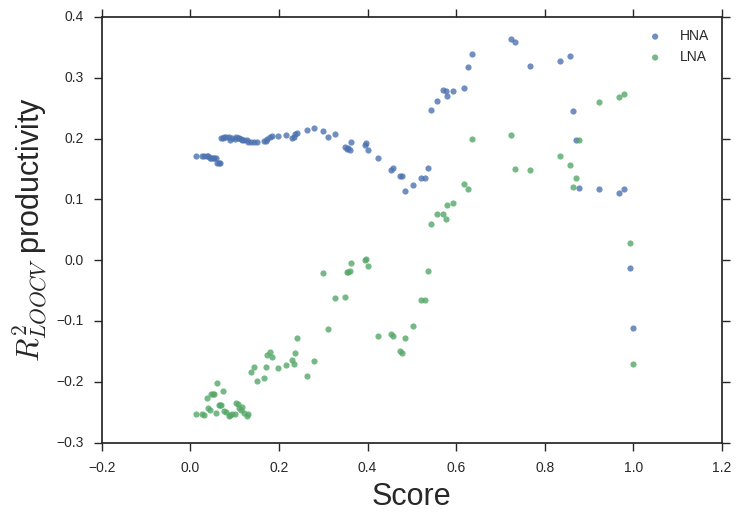

In [20]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_prod_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_prod_lna, fit_reg=False, label='LNA')
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2_{LOOCV}$ productivity', size=22)
plt.yticks(size=10)
plt.legend()
plt.show()

In [21]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.835835845542
Threshold score: [ 0.53]


In [63]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus_prod].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus_prod].std()/data_abs.loc[:,otus_prod].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus_prod].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus_prod].std()/data_rel.loc[:,otus_prod].mean())
otu_scores.to_csv('Final/hnascores_otus_prod_abun0.000001_rel.csv')

In [22]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
display(otu_scores_selected)
print('Size list selected OTUs: ' + str(len(selected_otus)))
#display(otu_scores_selected)

,score
Otu000173,1.000000
Otu000001,0.993333
Otu000060,0.980000
Otu000216,0.966667
Otu000059,0.923333
Otu000119,0.876667
Otu000160,0.870000
Otu000335,0.863333
Otu000176,0.856667
Otu000047,0.833333


Size list selected OTUs: 26


In [23]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.690780348043
